In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
from PIL import Image 
import tensorflow as tf
import keras.backend as K
from keras.applications import Xception
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization
from keras import Model
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tqdm import tqdm_notebook

### The Data

In [2]:
df_train = pd.read_csv('./input/severstal-steel-defect-detection/train.csv')

In [3]:
df_train['Defect'] = df_train['EncodedPixels'].notnull()
df_train['ClassId'] = df_train['ImageId_ClassId'].str[-1:]
df_train['ImageId'] = df_train['ImageId_ClassId'].str[:-2]

df_train = df_train[['ImageId','ClassId','Defect','EncodedPixels']]

In [4]:
df_train = df_train[df_train.Defect]
df_train = df_train.drop(['Defect'], axis=1)

In [5]:
df_train.shape

(7095, 3)

In [6]:
df_train.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
18,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
20,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
27,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
30,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


### Utility functions

In [7]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

In [8]:
img = [
    [0, 1, 0, 0, 0],
    [0, 1, 1, 1, 0], 
    [0, 1, 0, 1, 0],
    [0, 1, 1, 1, 0], 
    [0, 0, 0, 1, 0],
]

res = mask2rle(img)
print(res)

5 4 11 1 13 1 16 4


In [37]:
# This function uses a 0 based start index (arrays, matrixes and imgs start a index 0)
def rle2mask(rle, width, height):
    width = width
    height= height
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

In [10]:
res = rle2mask("5 4 11 1 13 1 16 4", (5, 5))
print(res)

[[0 1 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 1 0]]


### Xception Model in Keras

In [47]:
ORIG_IMG_SIZE_HEIGHT = 256
ORIG_IMG_SIZE_WIDTH = 1600
TRAIN_IMG_SIZE_HEIGHT = 96
TRAIN_IMG_SIZE_WIDTH = 608

NO_OF_CLASSES = 4

BATCH_SIZE = 2


In [40]:
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, img_path, orig_img_shape, new_img_shape=None, batch_size = BATCH_SIZE, n_channels=1,
                 n_classes=4, shuffle=False):
        super().__init__()
        self.df = df
        self.img_path = img_path
        self.orig_img_shape = orig_img_shape
        if new_img_shape:
            self.new_img_shape = new_img_shape
        else:
            self.new_img_shape = orig_img_shape
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size, *self.new_img_shape, self.n_channels), dtype=np.uint8)
        y = np.empty((self.batch_size, *self.new_img_shape, 1), dtype=np.uint8)
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        for idx, filename in enumerate(self.df['ImageId'].iloc[indexes]):
            print(filename)
            img = cv2.imread(self.img_path + filename, cv2.IMREAD_UNCHANGED)
            if self.orig_img_shape != self.new_img_shape:
                img = cv2.resize(img, tuple(reversed(self.new_img_shape)), interpolation=cv2.INTER_AREA)
            X[idx,] = img
            
            mask_i = rle2mask(self.df['EncodedPixels'].iloc[indexes[idx]], *self.orig_img_shape)            
            img_mask_i = Image.fromarray(mask_i, 'L')
            img_mask_np = np.array(img_mask_i) 
            
            if self.orig_img_shape != self.new_img_shape:
                img_mask_np = cv2.resize(img_mask_np, tuple(reversed(self.new_img_shape)), interpolation=cv2.INTER_AREA)
            y[idx,:,:,0] = img_mask_np
            
        return X, y

In [27]:
def dice_coeff(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    loss = 0.5 * binary_crossentropy(y_true, y_pred) - 2*dice_coeff(y_true, y_pred)
    return loss


In [41]:
base_model = Xception(weights='imagenet', input_shape=(TRAIN_IMG_SIZE_HEIGHT, TRAIN_IMG_SIZE_WIDTH, 3), include_top=False) #include_top=False excludes final FC layer
base_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 96, 608, 3)   0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 47, 303, 32)  864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 47, 303, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 47, 303, 32)  0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

block5_sepconv1_bn (BatchNormal (None, 6, 38, 728)   2912        block5_sepconv1[0][0]            
__________________________________________________________________________________________________
block5_sepconv2_act (Activation (None, 6, 38, 728)   0           block5_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block5_sepconv2 (SeparableConv2 (None, 6, 38, 728)   536536      block5_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv2_bn (BatchNormal (None, 6, 38, 728)   2912        block5_sepconv2[0][0]            
__________________________________________________________________________________________________
block5_sepconv3_act (Activation (None, 6, 38, 728)   0           block5_sepconv2_bn[0][0]         
__________________________________________________________________________________________________
block5_sep

block9_sepconv1 (SeparableConv2 (None, 6, 38, 728)   536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 6, 38, 728)   2912        block9_sepconv1[0][0]            
__________________________________________________________________________________________________
block9_sepconv2_act (Activation (None, 6, 38, 728)   0           block9_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block9_sepconv2 (SeparableConv2 (None, 6, 38, 728)   536536      block9_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv2_bn (BatchNormal (None, 6, 38, 728)   2912        block9_sepconv2[0][0]            
__________________________________________________________________________________________________
block9_sep

block13_sepconv1_act (Activatio (None, 6, 38, 728)   0           add_35[0][0]                     
__________________________________________________________________________________________________
block13_sepconv1 (SeparableConv (None, 6, 38, 728)   536536      block13_sepconv1_act[0][0]       
__________________________________________________________________________________________________
block13_sepconv1_bn (BatchNorma (None, 6, 38, 728)   2912        block13_sepconv1[0][0]           
__________________________________________________________________________________________________
block13_sepconv2_act (Activatio (None, 6, 38, 728)   0           block13_sepconv1_bn[0][0]        
__________________________________________________________________________________________________
block13_sepconv2 (SeparableConv (None, 6, 38, 1024)  752024      block13_sepconv2_act[0][0]       
__________________________________________________________________________________________________
block13_se

In [42]:
base_out = base_model.output
up1 = UpSampling2D(32, interpolation='bilinear')(base_out)
conv1 = Conv2D(1, (1, 1))(up1)
conv1 = Activation('sigmoid')(conv1)

model = Model(base_model.input, conv1)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 96, 608, 3)   0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 47, 303, 32)  864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 47, 303, 32)  128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 47, 303, 32)  0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

block5_sepconv1_bn (BatchNormal (None, 6, 38, 728)   2912        block5_sepconv1[0][0]            
__________________________________________________________________________________________________
block5_sepconv2_act (Activation (None, 6, 38, 728)   0           block5_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block5_sepconv2 (SeparableConv2 (None, 6, 38, 728)   536536      block5_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block5_sepconv2_bn (BatchNormal (None, 6, 38, 728)   2912        block5_sepconv2[0][0]            
__________________________________________________________________________________________________
block5_sepconv3_act (Activation (None, 6, 38, 728)   0           block5_sepconv2_bn[0][0]         
__________________________________________________________________________________________________
block5_sep

block9_sepconv1 (SeparableConv2 (None, 6, 38, 728)   536536      block9_sepconv1_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv1_bn (BatchNormal (None, 6, 38, 728)   2912        block9_sepconv1[0][0]            
__________________________________________________________________________________________________
block9_sepconv2_act (Activation (None, 6, 38, 728)   0           block9_sepconv1_bn[0][0]         
__________________________________________________________________________________________________
block9_sepconv2 (SeparableConv2 (None, 6, 38, 728)   536536      block9_sepconv2_act[0][0]        
__________________________________________________________________________________________________
block9_sepconv2_bn (BatchNormal (None, 6, 38, 728)   2912        block9_sepconv2[0][0]            
__________________________________________________________________________________________________
block9_sep

block13_sepconv1_act (Activatio (None, 6, 38, 728)   0           add_35[0][0]                     
__________________________________________________________________________________________________
block13_sepconv1 (SeparableConv (None, 6, 38, 728)   536536      block13_sepconv1_act[0][0]       
__________________________________________________________________________________________________
block13_sepconv1_bn (BatchNorma (None, 6, 38, 728)   2912        block13_sepconv1[0][0]           
__________________________________________________________________________________________________
block13_sepconv2_act (Activatio (None, 6, 38, 728)   0           block13_sepconv1_bn[0][0]        
__________________________________________________________________________________________________
block13_sepconv2 (SeparableConv (None, 6, 38, 1024)  752024      block13_sepconv2_act[0][0]       
__________________________________________________________________________________________________
block13_se

In [43]:
from keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(lr=0.00075), loss=bce_dice_loss, metrics=['accuracy', dice_coeff])

In [44]:
# A decreasing learning rate schedule (continuous decrease)
def continuous_decay(epoch):
    initial_lrate = 0.01
    lr = initial_lrate * (0.1 ** int(epoch / 10))
    return lr

# Another decreasing learning rate schedule (stepped decrease)
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 5.0
    lr = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

def get_callback(patient):
    ES = EarlyStopping(
        monitor='loss', 
        patience=patient, 
        mode='max', 
        verbose=1)
    RR = ReduceLROnPlateau(
        monitor = 'loss', 
        factor = 0.5, 
        patience = patient / 2, 
        min_lr=0.000001, 
        verbose=1, 
        mode='max')
    LR = LearningRateScheduler(
        continuous_decay,
        verbose=1)
    MC = ModelCheckpoint(
        filepath='./Xcep_model_CD_LR0_01.h5', 
        save_best_only=True,
        verbose=1)
#    return [ES, RR, LR, MC]
#    return [ES, MC, RR]
    return [ES, MC, LR]


In [45]:
idx = int(0.8*len(df_train))
train_batches = DataGenerator(df_train.iloc[:idx], './input/severstal-steel-defect-detection/train_images/', 
                                    orig_img_shape=(256, 1600), new_img_shape=(96, 608), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, shuffle=False)
valid_batches = DataGenerator(df_train.iloc[idx:], './input/severstal-steel-defect-detection/train_images/', 
                                    orig_img_shape=(256, 1600), new_img_shape=(96, 608), batch_size = BATCH_SIZE, 
                                    n_channels=3, n_classes=4, shuffle=False)

history = model.fit_generator(train_batches,
                              epochs=1,    
                              validation_data=valid_batches,
                              verbose=1,
                              shuffle=True,
                              callbacks = get_callback(2)
                             )

Epoch 1/1cc61104ff.jpg

c199d741a.jpg
cc69501eb.jpg
c1a90e9c8.jpg
cc73c4765.jpg
abe8e7faf.jpg
cc7920c72.jpg
cc7c66720.jpg
abedd15e2.jpg
cc8f6ee56.jpg
181d5197b.jpg
cc9006402.jpg
1821dcbf1.jpg
cc93ff156.jpg
cc9e159dd.jpg
782cfb1c5.jpg
ccbd751f2.jpg
ccbeeb18a.jpg78416c3d0.jpg

ccd0ad960.jpg
ae6b5adc2.jpg
ccd94dc85.jpg
ae6d0bf01.jpg
ccf39a604.jpg
cd04164a0.jpg
2a113071b.jpg
cd0c2417f.jpg
2a184dcbe.jpg
cd14c73db.jpg
cd14c73db.jpg
08f0b26ac.jpg
cd1f8d368.jpg
08f5c0997.jpg
cd23a468a.jpg
add980018.jpg
cd23d4841.jpg
cd316b37e.jpg
addd390e9.jpg
65b6e175c.jpg
65b962305.jpg
1d0861206.jpg
1d28002da.jpg
2c445e6a9.jpg
2c4b101db.jpg

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
76ff61cb4.jpg
77064b126.jpg
   1/2838 [..............................] - ETA: 11:20:24 - loss: 0.2084 - acc: 0.6699 - dice_coeff: 0.0430b90f74ebe.jpg
b913b77cc.jpg
   2/2838 [..............................] - ETA: 5:45:29 - loss: 0.3146 - acc: 0.7034 - dice_coeff: 0.0408 162fbb1af.jpg
163473240.jpg
   3/28

7b545550c.jpg
  57/2838 [..............................] - ETA: 21:38 - loss: 0.1340 - acc: 0.9277 - dice_coeff: 0.0729c85ed5c64.jpg
c873d7724.jpg
  58/2838 [..............................] - ETA: 21:25 - loss: 0.1334 - acc: 0.9286 - dice_coeff: 0.07184d1444a12.jpg
4d35cc84e.jpg
  59/2838 [..............................] - ETA: 21:13 - loss: 0.1427 - acc: 0.9273 - dice_coeff: 0.0719108ea689b.jpg
10909b4bb.jpg
  60/2838 [..............................] - ETA: 21:02 - loss: 0.1414 - acc: 0.9278 - dice_coeff: 0.0710bdb24ff3b.jpg
bdb31300b.jpg
  61/2838 [..............................] - ETA: 20:50 - loss: 0.1389 - acc: 0.9289 - dice_coeff: 0.0702b229bd6b5.jpg
b22b846c8.jpg
  62/2838 [..............................] - ETA: 20:39 - loss: 0.1373 - acc: 0.9295 - dice_coeff: 0.0697670dc6f72.jpg
670dc6f72.jpg
  63/2838 [..............................] - ETA: 20:28 - loss: 0.1331 - acc: 0.9299 - dice_coeff: 0.0704a5b53e614.jpg
a5b7b7fcc.jpg
  64/2838 [..............................] - ETA: 20:18

 118/2838 [>.............................] - ETA: 15:18 - loss: 0.0803 - acc: 0.9230 - dice_coeff: 0.0847a71e53574.jpg
a71e7121c.jpg
 119/2838 [>.............................] - ETA: 15:15 - loss: 0.0792 - acc: 0.9221 - dice_coeff: 0.0849c0eb3a086.jpg
c10467a1f.jpg
 120/2838 [>.............................] - ETA: 15:12 - loss: 0.0795 - acc: 0.9217 - dice_coeff: 0.084889332ba01.jpg
8957f8d0e.jpg
 121/2838 [>.............................] - ETA: 15:09 - loss: 0.0775 - acc: 0.9220 - dice_coeff: 0.0852c314f43f3.jpg
c314f43f3.jpg
 122/2838 [>.............................] - ETA: 15:06 - loss: 0.0740 - acc: 0.9209 - dice_coeff: 0.0869726271bfe.jpg
726cff75f.jpg
 123/2838 [>.............................] - ETA: 15:03 - loss: 0.0763 - acc: 0.9203 - dice_coeff: 0.086549a46692e.jpg
49a46692e.jpg
 124/2838 [>.............................] - ETA: 15:00 - loss: 0.0762 - acc: 0.9205 - dice_coeff: 0.08605ad48b934.jpg
5ad48b934.jpg
 125/2838 [>.............................] - ETA: 14:58 - loss: 0.075

 179/2838 [>.............................] - ETA: 13:08 - loss: 0.0354 - acc: 0.9171 - dice_coeff: 0.0961242894fc4.jpg
2434f1395.jpg
 180/2838 [>.............................] - ETA: 13:07 - loss: 0.0334 - acc: 0.9171 - dice_coeff: 0.0967a33d86440.jpg
a33ec265a.jpg
 181/2838 [>.............................] - ETA: 13:05 - loss: 0.0331 - acc: 0.9173 - dice_coeff: 0.09641699951da.jpg
169baf9bb.jpg
 182/2838 [>.............................] - ETA: 13:04 - loss: 0.0319 - acc: 0.9173 - dice_coeff: 0.0965a0a34a07c.jpg
a0a58dd59.jpg
 183/2838 [>.............................] - ETA: 13:02 - loss: 0.0311 - acc: 0.9176 - dice_coeff: 0.0964cbd4afcc0.jpg
cbdb0828d.jpg
 184/2838 [>.............................] - ETA: 13:01 - loss: 0.0302 - acc: 0.9176 - dice_coeff: 0.0965a8312b3b0.jpg
a831d2806.jpg
 185/2838 [>.............................] - ETA: 12:59 - loss: 0.0317 - acc: 0.9173 - dice_coeff: 0.09691082cfe08.jpg
1086196e1.jpg
 186/2838 [>.............................] - ETA: 12:58 - loss: 0.032

 240/2838 [=>............................] - ETA: 11:58 - loss: 0.0139 - acc: 0.9183 - dice_coeff: 0.0991a75ec2a42.jpg
a763e8b83.jpg
 241/2838 [=>............................] - ETA: 11:57 - loss: 0.0139 - acc: 0.9185 - dice_coeff: 0.0988c49d3da1b.jpg
c4a074066.jpg
 242/2838 [=>............................] - ETA: 11:56 - loss: 0.0138 - acc: 0.9188 - dice_coeff: 0.0986810f96801.jpg
81137ae8b.jpg
 243/2838 [=>............................] - ETA: 11:55 - loss: 0.0136 - acc: 0.9190 - dice_coeff: 0.098478c34b020.jpg
78d2258f2.jpg
 244/2838 [=>............................] - ETA: 11:54 - loss: 0.0135 - acc: 0.9191 - dice_coeff: 0.09838651a4a06.jpg
865574894.jpg
 245/2838 [=>............................] - ETA: 11:53 - loss: 0.0132 - acc: 0.9194 - dice_coeff: 0.09815ed98fbe2.jpg
5edc97218.jpg
 246/2838 [=>............................] - ETA: 11:52 - loss: 0.0130 - acc: 0.9196 - dice_coeff: 0.097907ba16aba.jpg
07ba66beb.jpg
 247/2838 [=>............................] - ETA: 11:51 - loss: 0.013

 301/2838 [==>...........................] - ETA: 11:10 - loss: 0.0129 - acc: 0.9217 - dice_coeff: 0.0929a922edcb6.jpg
a9378655a.jpg
 302/2838 [==>...........................] - ETA: 11:10 - loss: 0.0126 - acc: 0.9216 - dice_coeff: 0.093012234aab8.jpg
12274ea9c.jpg
 303/2838 [==>...........................] - ETA: 11:09 - loss: 0.0128 - acc: 0.9216 - dice_coeff: 0.0928b3cea5fb4.jpg
b3d4ba1e2.jpg
 304/2838 [==>...........................] - ETA: 11:08 - loss: 0.0132 - acc: 0.9217 - dice_coeff: 0.09266fd820bb6.jpg
6fdd5f4ac.jpg
 305/2838 [==>...........................] - ETA: 11:08 - loss: 0.0134 - acc: 0.9220 - dice_coeff: 0.09237095ad89d.jpg
7095dc41e.jpg
 306/2838 [==>...........................] - ETA: 11:07 - loss: 0.0125 - acc: 0.9218 - dice_coeff: 0.0927085bcd104.jpg
08605c0eb.jpg
 307/2838 [==>...........................] - ETA: 11:06 - loss: 0.0126 - acc: 0.9220 - dice_coeff: 0.09254ef65d75b.jpg
4ef6c54c9.jpg
 308/2838 [==>...........................] - ETA: 11:06 - loss: 0.012

 362/2838 [==>...........................] - ETA: 10:34 - loss: -0.0295 - acc: 0.9204 - dice_coeff: 0.11159c2dc4bfc.jpg
9c33cdef5.jpg
 363/2838 [==>...........................] - ETA: 10:34 - loss: -0.0310 - acc: 0.9204 - dice_coeff: 0.112165d3d7a0c.jpg
65eed1612.jpg
 364/2838 [==>...........................] - ETA: 10:33 - loss: -0.0323 - acc: 0.9205 - dice_coeff: 0.11263e185a3fe.jpg
3e1ed281b.jpg
 365/2838 [==>...........................] - ETA: 10:33 - loss: -0.0335 - acc: 0.9203 - dice_coeff: 0.113617c821b3f.jpg
17d02873a.jpg
 366/2838 [==>...........................] - ETA: 10:32 - loss: -0.0350 - acc: 0.9202 - dice_coeff: 0.11451a20361c3.jpg
1a33e152d.jpg
 367/2838 [==>...........................] - ETA: 10:32 - loss: -0.0344 - acc: 0.9198 - dice_coeff: 0.1146848b66095.jpg
849d70baf.jpg
 368/2838 [==>...........................] - ETA: 10:31 - loss: -0.0342 - acc: 0.9193 - dice_coeff: 0.114908de8df60.jpg
08e3aadde.jpg
 369/2838 [==>...........................] - ETA: 10:31 - loss

 423/2838 [===>..........................] - ETA: 10:05 - loss: -0.0808 - acc: 0.9191 - dice_coeff: 0.13601e963d7f6.jpg
1e979fb66.jpg
 424/2838 [===>..........................] - ETA: 10:05 - loss: -0.0826 - acc: 0.9191 - dice_coeff: 0.136801338c0ea.jpg
0139dd004.jpg
 425/2838 [===>..........................] - ETA: 10:04 - loss: -0.0835 - acc: 0.9192 - dice_coeff: 0.13710d0ee7a51.jpg
0d13c2a23.jpg
 426/2838 [===>..........................] - ETA: 10:04 - loss: -0.0843 - acc: 0.9191 - dice_coeff: 0.13767c5918274.jpg
7c5918274.jpg
 427/2838 [===>..........................] - ETA: 10:03 - loss: -0.0841 - acc: 0.9191 - dice_coeff: 0.13758066b7589.jpg
8066b7589.jpg
 428/2838 [===>..........................] - ETA: 10:03 - loss: -0.0845 - acc: 0.9191 - dice_coeff: 0.1377ab1293c8f.jpg
ab13f368e.jpg
 429/2838 [===>..........................] - ETA: 10:02 - loss: -0.0860 - acc: 0.9191 - dice_coeff: 0.1383b5804f43f.jpg
b58132808.jpg
 430/2838 [===>..........................] - ETA: 10:02 - loss

 484/2838 [====>.........................] - ETA: 9:40 - loss: -0.1177 - acc: 0.9176 - dice_coeff: 0.1527002fc4e19.jpg
002fc4e19.jpg
 485/2838 [====>.........................] - ETA: 9:39 - loss: -0.1179 - acc: 0.9177 - dice_coeff: 0.15277c95f2d2d.jpg
7c98d8010.jpg
 486/2838 [====>.........................] - ETA: 9:39 - loss: -0.1179 - acc: 0.9178 - dice_coeff: 0.152566c487b25.jpg
66c7d94b2.jpg
 487/2838 [====>.........................] - ETA: 9:39 - loss: -0.1194 - acc: 0.9178 - dice_coeff: 0.1532949a23e72.jpg
949a23e72.jpg
 488/2838 [====>.........................] - ETA: 9:38 - loss: -0.1205 - acc: 0.9178 - dice_coeff: 0.15378177945a9.jpg
817a545aa.jpg
 489/2838 [====>.........................] - ETA: 9:38 - loss: -0.1204 - acc: 0.9178 - dice_coeff: 0.15366181b0a92.jpg
61835d07a.jpg
 490/2838 [====>.........................] - ETA: 9:37 - loss: -0.1212 - acc: 0.9179 - dice_coeff: 0.1538b0bd510db.jpg
b0e0b8842.jpg
 491/2838 [====>.........................] - ETA: 9:37 - loss: -0.121

 545/2838 [====>.........................] - ETA: 9:17 - loss: -0.1458 - acc: 0.9186 - dice_coeff: 0.16379883f9819.jpg
988afc273.jpg
 546/2838 [====>.........................] - ETA: 9:17 - loss: -0.1459 - acc: 0.9186 - dice_coeff: 0.163623c9c6cba.jpg
23d77b3df.jpg
 547/2838 [====>.........................] - ETA: 9:17 - loss: -0.1466 - acc: 0.9187 - dice_coeff: 0.1639c3ff1a7cd.jpg
c3ff6937c.jpg
 548/2838 [====>.........................] - ETA: 9:16 - loss: -0.1491 - acc: 0.9188 - dice_coeff: 0.16509a5e9e77c.jpg
9a70057c0.jpg
 549/2838 [====>.........................] - ETA: 9:16 - loss: -0.1489 - acc: 0.9187 - dice_coeff: 0.1651b6b66ca8c.jpg
b6c0a38e9.jpg
 550/2838 [====>.........................] - ETA: 9:16 - loss: -0.1493 - acc: 0.9187 - dice_coeff: 0.165200e0398ad.jpg
00ec97699.jpg
 551/2838 [====>.........................] - ETA: 9:15 - loss: -0.1503 - acc: 0.9188 - dice_coeff: 0.165641f5ea1f2.jpg
41f5ea1f2.jpg
 552/2838 [====>.........................] - ETA: 9:15 - loss: -0.150

 606/2838 [=====>........................] - ETA: 8:57 - loss: -0.1640 - acc: 0.9181 - dice_coeff: 0.1710c293952c8.jpg
c2a409a0b.jpg
 607/2838 [=====>........................] - ETA: 8:56 - loss: -0.1651 - acc: 0.9182 - dice_coeff: 0.17158d74ea350.jpg
8d83b39c0.jpg
 608/2838 [=====>........................] - ETA: 8:56 - loss: -0.1652 - acc: 0.9182 - dice_coeff: 0.17157e18303fd.jpg
7e25a3973.jpg
 609/2838 [=====>........................] - ETA: 8:56 - loss: -0.1655 - acc: 0.9182 - dice_coeff: 0.1716398ff41cf.jpg
39960c9e9.jpg
 610/2838 [=====>........................] - ETA: 8:55 - loss: -0.1659 - acc: 0.9183 - dice_coeff: 0.17174bb7baa20.jpg
4bba4f866.jpg
 611/2838 [=====>........................] - ETA: 8:55 - loss: -0.1658 - acc: 0.9181 - dice_coeff: 0.17186ac1c730f.jpg
6ac1d05d3.jpg
 612/2838 [=====>........................] - ETA: 8:55 - loss: -0.1653 - acc: 0.9181 - dice_coeff: 0.17159ea9ca4c8.jpg
9eaaf83d7.jpg
 613/2838 [=====>........................] - ETA: 8:54 - loss: -0.166

 667/2838 [======>.......................] - ETA: 8:37 - loss: -0.1824 - acc: 0.9185 - dice_coeff: 0.178775e1310cc.jpg
75e84fb14.jpg
 668/2838 [======>.......................] - ETA: 8:37 - loss: -0.1831 - acc: 0.9185 - dice_coeff: 0.179164dc9ef9a.jpg
64fc246e7.jpg
 669/2838 [======>.......................] - ETA: 8:37 - loss: -0.1832 - acc: 0.9185 - dice_coeff: 0.179130070d59d.jpg
300a00766.jpg
 670/2838 [======>.......................] - ETA: 8:36 - loss: -0.1833 - acc: 0.9186 - dice_coeff: 0.1791b56de2940.jpg
b5730acdd.jpg
 671/2838 [======>.......................] - ETA: 8:36 - loss: -0.1837 - acc: 0.9186 - dice_coeff: 0.17925b537b5fa.jpg
5b53fc5e8.jpg
 672/2838 [======>.......................] - ETA: 8:36 - loss: -0.1838 - acc: 0.9186 - dice_coeff: 0.17935e5f3ea95.jpg
5e5f3ea95.jpg
 673/2838 [======>.......................] - ETA: 8:35 - loss: -0.1844 - acc: 0.9186 - dice_coeff: 0.179542695cb60.jpg
427085ef4.jpg
 674/2838 [======>.......................] - ETA: 8:35 - loss: -0.184

 728/2838 [======>.......................] - ETA: 8:19 - loss: -0.2018 - acc: 0.9203 - dice_coeff: 0.1861cc02b6f5a.jpg
cc0bf97cf.jpg
 729/2838 [======>.......................] - ETA: 8:18 - loss: -0.2025 - acc: 0.9204 - dice_coeff: 0.1865594303084.jpg
594d97d26.jpg
 730/2838 [======>.......................] - ETA: 8:18 - loss: -0.2028 - acc: 0.9204 - dice_coeff: 0.186637f4c573f.jpg
37f4e9602.jpg
 731/2838 [======>.......................] - ETA: 8:18 - loss: -0.2031 - acc: 0.9204 - dice_coeff: 0.186782aafd015.jpg
82ab1eb7f.jpg
 732/2838 [======>.......................] - ETA: 8:18 - loss: -0.2033 - acc: 0.9204 - dice_coeff: 0.1868139b7e692.jpg
139b7e692.jpg
 733/2838 [======>.......................] - ETA: 8:17 - loss: -0.2032 - acc: 0.9204 - dice_coeff: 0.18683f536622f.jpg
3f7e10763.jpg
 734/2838 [======>.......................] - ETA: 8:17 - loss: -0.2039 - acc: 0.9204 - dice_coeff: 0.18712b16d6f98.jpg
2b1d39d53.jpg
 735/2838 [======>.......................] - ETA: 8:17 - loss: -0.204

 789/2838 [=======>......................] - ETA: 8:01 - loss: -0.2181 - acc: 0.9203 - dice_coeff: 0.19412bdb48c91.jpg
2be0179d7.jpg
 790/2838 [=======>......................] - ETA: 8:01 - loss: -0.2176 - acc: 0.9202 - dice_coeff: 0.19403a7d9b5c1.jpg
3a7eee423.jpg
 791/2838 [=======>......................] - ETA: 8:01 - loss: -0.2180 - acc: 0.9202 - dice_coeff: 0.194286654180d.jpg
86752d23a.jpg
 792/2838 [=======>......................] - ETA: 8:00 - loss: -0.2185 - acc: 0.9203 - dice_coeff: 0.19446705eb964.jpg
670b74b68.jpg
 793/2838 [=======>......................] - ETA: 8:00 - loss: -0.2186 - acc: 0.9203 - dice_coeff: 0.1943c5ee627e2.jpg
c5f88471b.jpg
 794/2838 [=======>......................] - ETA: 8:00 - loss: -0.2185 - acc: 0.9204 - dice_coeff: 0.1942c543e902b.jpg
c54db71af.jpg
 795/2838 [=======>......................] - ETA: 8:00 - loss: -0.2183 - acc: 0.9203 - dice_coeff: 0.1942760bc3180.jpg
7612f0d6c.jpg
 796/2838 [=======>......................] - ETA: 7:59 - loss: -0.218

 850/2838 [=======>......................] - ETA: 7:44 - loss: -0.2360 - acc: 0.9206 - dice_coeff: 0.20215dd5484fc.jpg
5dd89309f.jpg
 851/2838 [=======>......................] - ETA: 7:44 - loss: -0.2360 - acc: 0.9207 - dice_coeff: 0.2021910ad3edf.jpg
911d78b0a.jpg
 852/2838 [========>.....................] - ETA: 7:44 - loss: -0.2358 - acc: 0.9205 - dice_coeff: 0.20242dc31340a.jpg
2dc3dd0a6.jpg
 853/2838 [========>.....................] - ETA: 7:44 - loss: -0.2362 - acc: 0.9203 - dice_coeff: 0.20265f2223804.jpg
5f28ca6de.jpg
 854/2838 [========>.....................] - ETA: 7:43 - loss: -0.2363 - acc: 0.9203 - dice_coeff: 0.2026af828b126.jpg
afb3e0467.jpg
 855/2838 [========>.....................] - ETA: 7:43 - loss: -0.2373 - acc: 0.9203 - dice_coeff: 0.2030b2461e55e.jpg
b2488a745.jpg
 856/2838 [========>.....................] - ETA: 7:43 - loss: -0.2379 - acc: 0.9204 - dice_coeff: 0.20333fcd061fc.jpg
3fcd061fc.jpg
 857/2838 [========>.....................] - ETA: 7:43 - loss: -0.238

 911/2838 [========>.....................] - ETA: 7:28 - loss: -0.2506 - acc: 0.9201 - dice_coeff: 0.2097b69aaf096.jpg
b69d1ed6a.jpg
 912/2838 [========>.....................] - ETA: 7:28 - loss: -0.2507 - acc: 0.9201 - dice_coeff: 0.2096ab2300506.jpg
ab2541958.jpg
 913/2838 [========>.....................] - ETA: 7:27 - loss: -0.2507 - acc: 0.9201 - dice_coeff: 0.20964bc04da70.jpg
4bc13de99.jpg
 914/2838 [========>.....................] - ETA: 7:27 - loss: -0.2508 - acc: 0.9202 - dice_coeff: 0.2096b9752d783.jpg
b9888ed87.jpg
 915/2838 [========>.....................] - ETA: 7:27 - loss: -0.2508 - acc: 0.9202 - dice_coeff: 0.20952467e2b6e.jpg
247108a1c.jpg
 916/2838 [========>.....................] - ETA: 7:27 - loss: -0.2510 - acc: 0.9202 - dice_coeff: 0.2097bdee0e677.jpg
bdeee2086.jpg
 917/2838 [========>.....................] - ETA: 7:26 - loss: -0.2505 - acc: 0.9201 - dice_coeff: 0.2095a0d19387f.jpg
a0de93374.jpg
 918/2838 [========>.....................] - ETA: 7:26 - loss: -0.250

 972/2838 [=========>....................] - ETA: 7:12 - loss: -0.2570 - acc: 0.9209 - dice_coeff: 0.2120833433e81.jpg
8344ef24d.jpg
 973/2838 [=========>....................] - ETA: 7:12 - loss: -0.2568 - acc: 0.9209 - dice_coeff: 0.2120c67e243c8.jpg
c683195bf.jpg
 974/2838 [=========>....................] - ETA: 7:12 - loss: -0.2574 - acc: 0.9209 - dice_coeff: 0.2122b57c00a3f.jpg
b57d15322.jpg
 975/2838 [=========>....................] - ETA: 7:11 - loss: -0.2572 - acc: 0.9207 - dice_coeff: 0.21230986996f0.jpg
0988e13e7.jpg
 976/2838 [=========>....................] - ETA: 7:11 - loss: -0.2571 - acc: 0.9207 - dice_coeff: 0.212364361cd8b.jpg
643f181f4.jpg
 977/2838 [=========>....................] - ETA: 7:11 - loss: -0.2572 - acc: 0.9207 - dice_coeff: 0.2123373ebde8b.jpg
3740a6dd1.jpg
 978/2838 [=========>....................] - ETA: 7:11 - loss: -0.2572 - acc: 0.9207 - dice_coeff: 0.2123172e692e1.jpg
17383bd97.jpg
 979/2838 [=========>....................] - ETA: 7:10 - loss: -0.257

1033/2838 [=========>....................] - ETA: 6:56 - loss: -0.2667 - acc: 0.9210 - dice_coeff: 0.21615c68839d0.jpg
5c6cba0d4.jpg
1034/2838 [=========>....................] - ETA: 6:56 - loss: -0.2671 - acc: 0.9211 - dice_coeff: 0.216394882163b.jpg
948f9558f.jpg
1035/2838 [=========>....................] - ETA: 6:56 - loss: -0.2672 - acc: 0.9210 - dice_coeff: 0.21635da78dca1.jpg
5db4d2daa.jpg
1036/2838 [=========>....................] - ETA: 6:56 - loss: -0.2680 - acc: 0.9210 - dice_coeff: 0.2167bcef3582e.jpg
bd01b8daf.jpg
1037/2838 [=========>....................] - ETA: 6:55 - loss: -0.2689 - acc: 0.9211 - dice_coeff: 0.2171357dee65a.jpg
359442214.jpg
1038/2838 [=========>....................] - ETA: 6:55 - loss: -0.2690 - acc: 0.9211 - dice_coeff: 0.2171a21bfa25a.jpg
a21d00db9.jpg
1039/2838 [=========>....................] - ETA: 6:55 - loss: -0.2688 - acc: 0.9211 - dice_coeff: 0.2170b754c1efe.jpg
b76bbb3cf.jpg
1040/2838 [=========>....................] - ETA: 6:55 - loss: -0.269

1094/2838 [==========>...................] - ETA: 6:41 - loss: -0.2799 - acc: 0.9215 - dice_coeff: 0.2222b1c4d3872.jpg
b1c892c12.jpg
1095/2838 [==========>...................] - ETA: 6:41 - loss: -0.2799 - acc: 0.9215 - dice_coeff: 0.22216826c7bde.jpg
683ad3cc1.jpg
1096/2838 [==========>...................] - ETA: 6:40 - loss: -0.2803 - acc: 0.9215 - dice_coeff: 0.2223c878411d7.jpg
c87ca8539.jpg
1097/2838 [==========>...................] - ETA: 6:40 - loss: -0.2808 - acc: 0.9214 - dice_coeff: 0.2226a08e02e56.jpg
a0906d0b3.jpg
1098/2838 [==========>...................] - ETA: 6:40 - loss: -0.2816 - acc: 0.9214 - dice_coeff: 0.22301535e2127.jpg
153b56c43.jpg
1099/2838 [==========>...................] - ETA: 6:40 - loss: -0.2812 - acc: 0.9214 - dice_coeff: 0.22284345c2b85.jpg
4345db2fc.jpg
1100/2838 [==========>...................] - ETA: 6:39 - loss: -0.2810 - acc: 0.9214 - dice_coeff: 0.222776a390db7.jpg
76a7e1815.jpg
1101/2838 [==========>...................] - ETA: 6:39 - loss: -0.281

1155/2838 [===========>..................] - ETA: 6:26 - loss: -0.2899 - acc: 0.9217 - dice_coeff: 0.2265523fee62c.jpg
52497822f.jpg
1156/2838 [===========>..................] - ETA: 6:26 - loss: -0.2903 - acc: 0.9218 - dice_coeff: 0.22674f9b3eee7.jpg
4fb88c3a4.jpg
1157/2838 [===========>..................] - ETA: 6:25 - loss: -0.2904 - acc: 0.9218 - dice_coeff: 0.2267653a31140.jpg
653eb7e80.jpg
1158/2838 [===========>..................] - ETA: 6:25 - loss: -0.2907 - acc: 0.9218 - dice_coeff: 0.22687ff50bb90.jpg
7ff9e795d.jpg
1159/2838 [===========>..................] - ETA: 6:25 - loss: -0.2909 - acc: 0.9218 - dice_coeff: 0.2269140e212df.jpg
140e59cff.jpg
1160/2838 [===========>..................] - ETA: 6:25 - loss: -0.2910 - acc: 0.9218 - dice_coeff: 0.227082c806ebb.jpg
82cf55ab9.jpg
1161/2838 [===========>..................] - ETA: 6:24 - loss: -0.2914 - acc: 0.9218 - dice_coeff: 0.2272527517cf3.jpg
527b50f74.jpg
1162/2838 [===========>..................] - ETA: 6:24 - loss: -0.291

1216/2838 [===========>..................] - ETA: 6:11 - loss: -0.2981 - acc: 0.9215 - dice_coeff: 0.23053ecf33095.jpg
3ecff5d55.jpg
1217/2838 [===========>..................] - ETA: 6:11 - loss: -0.2983 - acc: 0.9215 - dice_coeff: 0.230747568c5de.jpg
476a0129a.jpg
1218/2838 [===========>..................] - ETA: 6:10 - loss: -0.2985 - acc: 0.9215 - dice_coeff: 0.23083e59e0f17.jpg
3e63fb99b.jpg
1219/2838 [===========>..................] - ETA: 6:10 - loss: -0.2981 - acc: 0.9215 - dice_coeff: 0.2306ae79304b2.jpg
ae7a2de0d.jpg
1220/2838 [===========>..................] - ETA: 6:10 - loss: -0.2989 - acc: 0.9215 - dice_coeff: 0.2310016af13d0.jpg
016efe618.jpg
1221/2838 [===========>..................] - ETA: 6:10 - loss: -0.2987 - acc: 0.9215 - dice_coeff: 0.230870dd2c2f8.jpg
70e4c95b6.jpg
1222/2838 [===========>..................] - ETA: 6:09 - loss: -0.2987 - acc: 0.9216 - dice_coeff: 0.230826b0e74fe.jpg
26b980260.jpg
1223/2838 [===========>..................] - ETA: 6:09 - loss: -0.298

1277/2838 [============>.................] - ETA: 5:56 - loss: -0.3066 - acc: 0.9216 - dice_coeff: 0.2346917cdbff6.jpg
918c32419.jpg
1278/2838 [============>.................] - ETA: 5:56 - loss: -0.3065 - acc: 0.9216 - dice_coeff: 0.234536a39e435.jpg
36a689ebf.jpg
1279/2838 [============>.................] - ETA: 5:55 - loss: -0.3064 - acc: 0.9217 - dice_coeff: 0.2345a634d3a24.jpg
a63669b29.jpg
1280/2838 [============>.................] - ETA: 5:55 - loss: -0.3065 - acc: 0.9217 - dice_coeff: 0.2345a02fe46b6.jpg
a045e21e6.jpg
1281/2838 [============>.................] - ETA: 5:55 - loss: -0.3066 - acc: 0.9217 - dice_coeff: 0.234586b7dbfe8.jpg
86c678c32.jpg
1282/2838 [============>.................] - ETA: 5:55 - loss: -0.3073 - acc: 0.9217 - dice_coeff: 0.2349037fca267.jpg
03860f6a9.jpg
1283/2838 [============>.................] - ETA: 5:55 - loss: -0.3075 - acc: 0.9218 - dice_coeff: 0.2349537e66c26.jpg
53994e13b.jpg
1284/2838 [============>.................] - ETA: 5:54 - loss: -0.307

1338/2838 [=============>................] - ETA: 5:41 - loss: -0.3172 - acc: 0.9218 - dice_coeff: 0.23972a74520ed.jpg
2a7f8bab0.jpg
1339/2838 [=============>................] - ETA: 5:41 - loss: -0.3178 - acc: 0.9219 - dice_coeff: 0.240050ff24e6e.jpg
51097aa45.jpg
1340/2838 [=============>................] - ETA: 5:41 - loss: -0.3176 - acc: 0.9218 - dice_coeff: 0.2399c131d5030.jpg
c135aedee.jpg
1341/2838 [=============>................] - ETA: 5:41 - loss: -0.3177 - acc: 0.9218 - dice_coeff: 0.24000dd76b019.jpg
0dd8c9f61.jpg
1342/2838 [=============>................] - ETA: 5:40 - loss: -0.3176 - acc: 0.9218 - dice_coeff: 0.23997cb5bd6f1.jpg
7cf4f552c.jpg
1343/2838 [=============>................] - ETA: 5:40 - loss: -0.3177 - acc: 0.9219 - dice_coeff: 0.24002912df978.jpg
2912e9e24.jpg
1344/2838 [=============>................] - ETA: 5:40 - loss: -0.3180 - acc: 0.9219 - dice_coeff: 0.24012558c43bf.jpg
2560e7b91.jpg
1345/2838 [=============>................] - ETA: 5:40 - loss: -0.317

1399/2838 [=============>................] - ETA: 5:27 - loss: -0.3233 - acc: 0.9214 - dice_coeff: 0.24287638de35f.jpg
764275950.jpg
1400/2838 [=============>................] - ETA: 5:27 - loss: -0.3235 - acc: 0.9214 - dice_coeff: 0.24287424ab9af.jpg
7435bcc25.jpg
1401/2838 [=============>................] - ETA: 5:26 - loss: -0.3234 - acc: 0.9214 - dice_coeff: 0.242843c0e310c.jpg
43c1e8a0b.jpg
1402/2838 [=============>................] - ETA: 5:26 - loss: -0.3233 - acc: 0.9214 - dice_coeff: 0.24272dcff4a4e.jpg
2dd290c91.jpg
1403/2838 [=============>................] - ETA: 5:26 - loss: -0.3240 - acc: 0.9214 - dice_coeff: 0.243086063fcba.jpg
8611deb61.jpg
1404/2838 [=============>................] - ETA: 5:26 - loss: -0.3247 - acc: 0.9215 - dice_coeff: 0.2433488c35cf9.jpg
489bc785a.jpg
1405/2838 [=============>................] - ETA: 5:25 - loss: -0.3253 - acc: 0.9215 - dice_coeff: 0.24367abb5b1b7.jpg
7abd14b6a.jpg
1406/2838 [=============>................] - ETA: 5:25 - loss: -0.325

1460/2838 [==============>...............] - ETA: 5:12 - loss: -0.3295 - acc: 0.9215 - dice_coeff: 0.245169205724f.jpg
69231176e.jpg
1461/2838 [==============>...............] - ETA: 5:12 - loss: -0.3296 - acc: 0.9214 - dice_coeff: 0.2452326d25e8c.jpg
326f2e4b7.jpg
1462/2838 [==============>...............] - ETA: 5:12 - loss: -0.3300 - acc: 0.9214 - dice_coeff: 0.24549be9c98eb.jpg
9beece43e.jpg
1463/2838 [==============>...............] - ETA: 5:12 - loss: -0.3300 - acc: 0.9214 - dice_coeff: 0.2454bbcf45362.jpg
bbd1b8f11.jpg
1464/2838 [==============>...............] - ETA: 5:11 - loss: -0.3299 - acc: 0.9214 - dice_coeff: 0.2453a5cb0256f.jpg
a5d571de0.jpg
1465/2838 [==============>...............] - ETA: 5:11 - loss: -0.3299 - acc: 0.9214 - dice_coeff: 0.2453a4d22b821.jpg
a4d3149e0.jpg
1466/2838 [==============>...............] - ETA: 5:11 - loss: -0.3296 - acc: 0.9214 - dice_coeff: 0.245281b6f3cca.jpg
81c37d5f1.jpg
1467/2838 [==============>...............] - ETA: 5:11 - loss: -0.329

1521/2838 [===============>..............] - ETA: 4:58 - loss: -0.3376 - acc: 0.9212 - dice_coeff: 0.2489c515ddabf.jpg
c51fb3d88.jpg
1522/2838 [===============>..............] - ETA: 4:58 - loss: -0.3378 - acc: 0.9212 - dice_coeff: 0.24905de4f67ec.jpg
5e0744d4b.jpg
1523/2838 [===============>..............] - ETA: 4:57 - loss: -0.3377 - acc: 0.9213 - dice_coeff: 0.2489303f25bee.jpg
304083ca3.jpg
1524/2838 [===============>..............] - ETA: 4:57 - loss: -0.3378 - acc: 0.9212 - dice_coeff: 0.24905892d9332.jpg
58b26c5f1.jpg
1525/2838 [===============>..............] - ETA: 4:57 - loss: -0.3377 - acc: 0.9212 - dice_coeff: 0.248909d84ff22.jpg
09d87038e.jpg
1526/2838 [===============>..............] - ETA: 4:57 - loss: -0.3377 - acc: 0.9212 - dice_coeff: 0.249046dd7fa76.jpg
46dfd5be4.jpg
1527/2838 [===============>..............] - ETA: 4:57 - loss: -0.3378 - acc: 0.9212 - dice_coeff: 0.24905ff5438f5.jpg
5ff6ee14c.jpg
1528/2838 [===============>..............] - ETA: 4:56 - loss: -0.338

1582/2838 [===============>..............] - ETA: 4:44 - loss: -0.3454 - acc: 0.9209 - dice_coeff: 0.2528465808594.jpg
46582cff8.jpg
1583/2838 [===============>..............] - ETA: 4:43 - loss: -0.3452 - acc: 0.9210 - dice_coeff: 0.2527bcc4f678a.jpg
bce091bac.jpg
1584/2838 [===============>..............] - ETA: 4:43 - loss: -0.3450 - acc: 0.9209 - dice_coeff: 0.2526352c15e36.jpg
353e60eef.jpg
1585/2838 [===============>..............] - ETA: 4:43 - loss: -0.3454 - acc: 0.9210 - dice_coeff: 0.252826272c2a7.jpg
262db4b7e.jpg
1586/2838 [===============>..............] - ETA: 4:43 - loss: -0.3454 - acc: 0.9210 - dice_coeff: 0.25289f6016bcc.jpg
9f7063103.jpg
1587/2838 [===============>..............] - ETA: 4:43 - loss: -0.3460 - acc: 0.9210 - dice_coeff: 0.2530babc63c5b.jpg
babc99f0c.jpg
1588/2838 [===============>..............] - ETA: 4:42 - loss: -0.3461 - acc: 0.9209 - dice_coeff: 0.2532b0f9fff35.jpg
b107bf5bd.jpg
1589/2838 [===============>..............] - ETA: 4:42 - loss: -0.346

1643/2838 [================>.............] - ETA: 4:29 - loss: -0.3545 - acc: 0.9215 - dice_coeff: 0.2566c2d0a2e19.jpg
c2eb19445.jpg
1644/2838 [================>.............] - ETA: 4:29 - loss: -0.3547 - acc: 0.9215 - dice_coeff: 0.25678886a8a54.jpg
889454305.jpg
1645/2838 [================>.............] - ETA: 4:29 - loss: -0.3549 - acc: 0.9215 - dice_coeff: 0.2568b1cf6d807.jpg
b1d3f12b6.jpg
1646/2838 [================>.............] - ETA: 4:29 - loss: -0.3552 - acc: 0.9215 - dice_coeff: 0.25693f0b1c635.jpg
3f272083c.jpg
1647/2838 [================>.............] - ETA: 4:29 - loss: -0.3550 - acc: 0.9215 - dice_coeff: 0.256836025df84.jpg
3604dfc38.jpg
1648/2838 [================>.............] - ETA: 4:28 - loss: -0.3549 - acc: 0.9215 - dice_coeff: 0.2568915b0078c.jpg
9163ec76b.jpg
1649/2838 [================>.............] - ETA: 4:28 - loss: -0.3546 - acc: 0.9215 - dice_coeff: 0.256832578d3e5.jpg
3266ff34d.jpg
1650/2838 [================>.............] - ETA: 4:28 - loss: -0.354

1704/2838 [=================>............] - ETA: 4:15 - loss: -0.3608 - acc: 0.9216 - dice_coeff: 0.25984ade4b747.jpg
4af0f0204.jpg
1705/2838 [=================>............] - ETA: 4:15 - loss: -0.3611 - acc: 0.9216 - dice_coeff: 0.259902c4655ff.jpg
02c79bfcb.jpg
1706/2838 [=================>............] - ETA: 4:15 - loss: -0.3612 - acc: 0.9216 - dice_coeff: 0.26006668e50d0.jpg
66849c8bd.jpg
1707/2838 [=================>............] - ETA: 4:15 - loss: -0.3614 - acc: 0.9216 - dice_coeff: 0.260147d9b630e.jpg
47dc31ace.jpg
1708/2838 [=================>............] - ETA: 4:14 - loss: -0.3615 - acc: 0.9216 - dice_coeff: 0.260244a1e7d5f.jpg
44a2e6e51.jpg
1709/2838 [=================>............] - ETA: 4:14 - loss: -0.3618 - acc: 0.9216 - dice_coeff: 0.26037a8a7403c.jpg
7a8a7403c.jpg
1710/2838 [=================>............] - ETA: 4:14 - loss: -0.3617 - acc: 0.9216 - dice_coeff: 0.260349416ce82.jpg
494ead378.jpg
1711/2838 [=================>............] - ETA: 4:14 - loss: -0.361

1765/2838 [=================>............] - ETA: 4:01 - loss: -0.3656 - acc: 0.9220 - dice_coeff: 0.26199fab4894b.jpg
9fac588ab.jpg
1766/2838 [=================>............] - ETA: 4:01 - loss: -0.3659 - acc: 0.9220 - dice_coeff: 0.26216de9ff56a.jpg
6defb795f.jpg
1767/2838 [=================>............] - ETA: 4:01 - loss: -0.3662 - acc: 0.9220 - dice_coeff: 0.262244ada0c0b.jpg
44aea3a11.jpg
1768/2838 [=================>............] - ETA: 4:01 - loss: -0.3661 - acc: 0.9220 - dice_coeff: 0.26225a4ca9b10.jpg
5a620fd1e.jpg
1769/2838 [=================>............] - ETA: 4:00 - loss: -0.3662 - acc: 0.9219 - dice_coeff: 0.262295b95a425.jpg
95d88196d.jpg
1770/2838 [=================>............] - ETA: 4:00 - loss: -0.3663 - acc: 0.9219 - dice_coeff: 0.26237a5fae002.jpg
7a7282702.jpg
1771/2838 [=================>............] - ETA: 4:00 - loss: -0.3661 - acc: 0.9219 - dice_coeff: 0.2622a3c3733cd.jpg
a3c477831.jpg
1772/2838 [=================>............] - ETA: 4:00 - loss: -0.366

1826/2838 [==================>...........] - ETA: 3:47 - loss: -0.3720 - acc: 0.9220 - dice_coeff: 0.264905f5e7366.jpg
0602f0520.jpg
1827/2838 [==================>...........] - ETA: 3:47 - loss: -0.3724 - acc: 0.9220 - dice_coeff: 0.2651bf9b21859.jpg
bfa17327e.jpg
1828/2838 [==================>...........] - ETA: 3:47 - loss: -0.3726 - acc: 0.9220 - dice_coeff: 0.2652aad347618.jpg
aae6bc5be.jpg
1829/2838 [==================>...........] - ETA: 3:47 - loss: -0.3728 - acc: 0.9220 - dice_coeff: 0.265320964a4f0.jpg
20964a4f0.jpg
1830/2838 [==================>...........] - ETA: 3:46 - loss: -0.3728 - acc: 0.9220 - dice_coeff: 0.265322031aa8f.jpg
22123f29f.jpg
1831/2838 [==================>...........] - ETA: 3:46 - loss: -0.3731 - acc: 0.9221 - dice_coeff: 0.26541eb697fe5.jpg
1ebd7aba5.jpg
1832/2838 [==================>...........] - ETA: 3:46 - loss: -0.3729 - acc: 0.9221 - dice_coeff: 0.26538a17572d8.jpg
8a2a8a476.jpg
1833/2838 [==================>...........] - ETA: 3:46 - loss: -0.373

1887/2838 [==================>...........] - ETA: 3:33 - loss: -0.3793 - acc: 0.9224 - dice_coeff: 0.2685927100ebb.jpg
9271c7e3d.jpg
1888/2838 [==================>...........] - ETA: 3:33 - loss: -0.3795 - acc: 0.9224 - dice_coeff: 0.268503461f8e0.jpg
034941f9d.jpg
1889/2838 [==================>...........] - ETA: 3:33 - loss: -0.3792 - acc: 0.9224 - dice_coeff: 0.268431dee4189.jpg
31e86cf3a.jpg
1890/2838 [==================>...........] - ETA: 3:33 - loss: -0.3793 - acc: 0.9224 - dice_coeff: 0.26846e99aef86.jpg
6ea9f03a2.jpg
1891/2838 [==================>...........] - ETA: 3:32 - loss: -0.3795 - acc: 0.9224 - dice_coeff: 0.268559bcf1693.jpg
59c00ad1f.jpg
1892/2838 [===================>..........] - ETA: 3:32 - loss: -0.3797 - acc: 0.9224 - dice_coeff: 0.2686a6980dd61.jpg
a69fb48e2.jpg
1893/2838 [===================>..........] - ETA: 3:32 - loss: -0.3796 - acc: 0.9224 - dice_coeff: 0.2685349be04dc.jpg
34a5114d6.jpg
1894/2838 [===================>..........] - ETA: 3:32 - loss: -0.379

1948/2838 [===================>..........] - ETA: 3:19 - loss: -0.3851 - acc: 0.9225 - dice_coeff: 0.27140905fe055.jpg
090a6a4b5.jpg
1949/2838 [===================>..........] - ETA: 3:19 - loss: -0.3854 - acc: 0.9225 - dice_coeff: 0.2715738850f07.jpg
7393b145f.jpg
1950/2838 [===================>..........] - ETA: 3:19 - loss: -0.3855 - acc: 0.9225 - dice_coeff: 0.27157e63e3baf.jpg
7e65bb413.jpg
1951/2838 [===================>..........] - ETA: 3:19 - loss: -0.3855 - acc: 0.9225 - dice_coeff: 0.2715c057d7bc1.jpg
c0598f956.jpg
1952/2838 [===================>..........] - ETA: 3:18 - loss: -0.3857 - acc: 0.9225 - dice_coeff: 0.2716a94abfda7.jpg
a97abc0aa.jpg
1953/2838 [===================>..........] - ETA: 3:18 - loss: -0.3856 - acc: 0.9225 - dice_coeff: 0.27164803fc0ae.jpg
483e4b5f7.jpg
1954/2838 [===================>..........] - ETA: 3:18 - loss: -0.3856 - acc: 0.9226 - dice_coeff: 0.2715549613483.jpg
549aa706e.jpg
1955/2838 [===================>..........] - ETA: 3:18 - loss: -0.385

2009/2838 [====================>.........] - ETA: 3:05 - loss: -0.3898 - acc: 0.9224 - dice_coeff: 0.27363b4c484d0.jpg
3b4c8b9a4.jpg
2010/2838 [====================>.........] - ETA: 3:05 - loss: -0.3898 - acc: 0.9223 - dice_coeff: 0.2737bd77f2c37.jpg
bd794618f.jpg
2011/2838 [====================>.........] - ETA: 3:05 - loss: -0.3897 - acc: 0.9224 - dice_coeff: 0.2736b5867dc30.jpg
b595566b3.jpg
2012/2838 [====================>.........] - ETA: 3:05 - loss: -0.3898 - acc: 0.9224 - dice_coeff: 0.27366308e03ad.jpg
631774933.jpg
2013/2838 [====================>.........] - ETA: 3:05 - loss: -0.3899 - acc: 0.9223 - dice_coeff: 0.27376ccde604d.jpg
6ce526a3a.jpg
2014/2838 [====================>.........] - ETA: 3:04 - loss: -0.3902 - acc: 0.9223 - dice_coeff: 0.273899743b154.jpg
99855ae32.jpg
2015/2838 [====================>.........] - ETA: 3:04 - loss: -0.3904 - acc: 0.9224 - dice_coeff: 0.273970639811b.jpg
7063cb92d.jpg
2016/2838 [====================>.........] - ETA: 3:04 - loss: -0.390

2070/2838 [====================>.........] - ETA: 2:52 - loss: -0.3958 - acc: 0.9226 - dice_coeff: 0.2764946525536.jpg
94753d945.jpg
2071/2838 [====================>.........] - ETA: 2:51 - loss: -0.3962 - acc: 0.9226 - dice_coeff: 0.27666246f7cae.jpg
624b76e5c.jpg
2072/2838 [====================>.........] - ETA: 2:51 - loss: -0.3963 - acc: 0.9226 - dice_coeff: 0.2766bfd38637f.jpg
bfd56c3d2.jpg
2073/2838 [====================>.........] - ETA: 2:51 - loss: -0.3962 - acc: 0.9226 - dice_coeff: 0.27660888e6a84.jpg
0888e6a84.jpg
2074/2838 [====================>.........] - ETA: 2:51 - loss: -0.3961 - acc: 0.9226 - dice_coeff: 0.27666d9559d13.jpg
6d97f7c81.jpg
2075/2838 [====================>.........] - ETA: 2:51 - loss: -0.3963 - acc: 0.9226 - dice_coeff: 0.2767551b840d2.jpg
55303df62.jpg
2076/2838 [====================>.........] - ETA: 2:50 - loss: -0.3962 - acc: 0.9226 - dice_coeff: 0.27661c96b0bbc.jpg
1c97d1861.jpg
2077/2838 [====================>.........] - ETA: 2:50 - loss: -0.396

2131/2838 [=====================>........] - ETA: 2:38 - loss: -0.4014 - acc: 0.9222 - dice_coeff: 0.2793ac48ab24b.jpg
ac4ba5c1a.jpg
2132/2838 [=====================>........] - ETA: 2:38 - loss: -0.4017 - acc: 0.9222 - dice_coeff: 0.2794c571c7c32.jpg
c57607580.jpg
2133/2838 [=====================>........] - ETA: 2:37 - loss: -0.4015 - acc: 0.9222 - dice_coeff: 0.2793485ed6221.jpg
48626da29.jpg
2134/2838 [=====================>........] - ETA: 2:37 - loss: -0.4016 - acc: 0.9222 - dice_coeff: 0.279398bb49ca7.jpg
98bb73faf.jpg
2135/2838 [=====================>........] - ETA: 2:37 - loss: -0.4015 - acc: 0.9222 - dice_coeff: 0.27927329b8668.jpg
732bd67ee.jpg
2136/2838 [=====================>........] - ETA: 2:37 - loss: -0.4015 - acc: 0.9222 - dice_coeff: 0.27921ef476f3c.jpg
1efdd626e.jpg
2137/2838 [=====================>........] - ETA: 2:36 - loss: -0.4014 - acc: 0.9222 - dice_coeff: 0.279137333b84a.jpg
3738d1881.jpg
2138/2838 [=====================>........] - ETA: 2:36 - loss: -0.401

2192/2838 [======================>.......] - ETA: 2:24 - loss: -0.4037 - acc: 0.9222 - dice_coeff: 0.28000728b2ac9.jpg
0739e9688.jpg
2193/2838 [======================>.......] - ETA: 2:24 - loss: -0.4040 - acc: 0.9222 - dice_coeff: 0.28018527d0b55.jpg
8527d0b55.jpg
2194/2838 [======================>.......] - ETA: 2:24 - loss: -0.4041 - acc: 0.9221 - dice_coeff: 0.28025aa352ece.jpg
5aa7997bd.jpg
2195/2838 [======================>.......] - ETA: 2:23 - loss: -0.4041 - acc: 0.9221 - dice_coeff: 0.280204ae7853c.jpg
04c3aade7.jpg
2196/2838 [======================>.......] - ETA: 2:23 - loss: -0.4041 - acc: 0.9221 - dice_coeff: 0.280151d7bee0a.jpg
51ee8ec48.jpg
2197/2838 [======================>.......] - ETA: 2:23 - loss: -0.4043 - acc: 0.9221 - dice_coeff: 0.28039f34c4775.jpg
9f43931af.jpg
2198/2838 [======================>.......] - ETA: 2:23 - loss: -0.4042 - acc: 0.9221 - dice_coeff: 0.2802bf83e7037.jpg
bf96d0602.jpg
2199/2838 [======================>.......] - ETA: 2:22 - loss: -0.404

2253/2838 [======================>.......] - ETA: 2:10 - loss: -0.4106 - acc: 0.9220 - dice_coeff: 0.2834aee20074e.jpg
aefa93267.jpg
2254/2838 [======================>.......] - ETA: 2:10 - loss: -0.4108 - acc: 0.9220 - dice_coeff: 0.28356a06e0328.jpg
6a15b9733.jpg
2255/2838 [======================>.......] - ETA: 2:10 - loss: -0.4111 - acc: 0.9220 - dice_coeff: 0.2836802de5801.jpg
805ea1870.jpg
2256/2838 [======================>.......] - ETA: 2:10 - loss: -0.4110 - acc: 0.9220 - dice_coeff: 0.2836975b2e5fa.jpg
975e50a09.jpg
2257/2838 [======================>.......] - ETA: 2:09 - loss: -0.4114 - acc: 0.9220 - dice_coeff: 0.283706e6582af.jpg
06e6e7a8c.jpg
2258/2838 [======================>.......] - ETA: 2:09 - loss: -0.4112 - acc: 0.9220 - dice_coeff: 0.2836ac8edd837.jpg
ac912ddc4.jpg
2259/2838 [======================>.......] - ETA: 2:09 - loss: -0.4116 - acc: 0.9220 - dice_coeff: 0.2838bbae1c48a.jpg
bbaeed54e.jpg
2260/2838 [======================>.......] - ETA: 2:09 - loss: -0.411

2314/2838 [=======================>......] - ETA: 1:57 - loss: -0.4159 - acc: 0.9221 - dice_coeff: 0.286072df2d40d.jpg
72e49c314.jpg
2315/2838 [=======================>......] - ETA: 1:56 - loss: -0.4161 - acc: 0.9221 - dice_coeff: 0.2861741265573.jpg
74131d9ff.jpg
2316/2838 [=======================>......] - ETA: 1:56 - loss: -0.4163 - acc: 0.9222 - dice_coeff: 0.2862724dd91a0.jpg
72613a1e3.jpg
2317/2838 [=======================>......] - ETA: 1:56 - loss: -0.4164 - acc: 0.9222 - dice_coeff: 0.28627365300fe.jpg
736c09835.jpg
2318/2838 [=======================>......] - ETA: 1:56 - loss: -0.4166 - acc: 0.9222 - dice_coeff: 0.2863b7d19b506.jpg
b7dab02ec.jpg
2319/2838 [=======================>......] - ETA: 1:55 - loss: -0.4168 - acc: 0.9222 - dice_coeff: 0.28637ed64642e.jpg
7ee479373.jpg
2320/2838 [=======================>......] - ETA: 1:55 - loss: -0.4169 - acc: 0.9222 - dice_coeff: 0.2864744e852d6.jpg
7454d922e.jpg
2321/2838 [=======================>......] - ETA: 1:55 - loss: -0.416

2375/2838 [========================>.....] - ETA: 1:43 - loss: -0.4186 - acc: 0.9219 - dice_coeff: 0.287459e91f935.jpg
59f0c09bb.jpg
2376/2838 [========================>.....] - ETA: 1:43 - loss: -0.4189 - acc: 0.9219 - dice_coeff: 0.28764adc459d5.jpg
4ade4b747.jpg
2377/2838 [========================>.....] - ETA: 1:42 - loss: -0.4189 - acc: 0.9219 - dice_coeff: 0.28768a7121b61.jpg
8a75d73d9.jpg
2378/2838 [========================>.....] - ETA: 1:42 - loss: -0.4192 - acc: 0.9219 - dice_coeff: 0.2877aeb34560d.jpg
aeb94b95f.jpg
2379/2838 [========================>.....] - ETA: 1:42 - loss: -0.4195 - acc: 0.9219 - dice_coeff: 0.2879a77af14dd.jpg
a77b147af.jpg
2380/2838 [========================>.....] - ETA: 1:42 - loss: -0.4200 - acc: 0.9219 - dice_coeff: 0.2881631c2334a.jpg
631eb3826.jpg
2381/2838 [========================>.....] - ETA: 1:42 - loss: -0.4200 - acc: 0.9219 - dice_coeff: 0.28812f6858a91.jpg
2f69f62ae.jpg
2382/2838 [========================>.....] - ETA: 1:41 - loss: -0.420

2436/2838 [========================>.....] - ETA: 1:29 - loss: -0.4218 - acc: 0.9219 - dice_coeff: 0.28899a83c23d1.jpg
9a8c769b4.jpg
2437/2838 [========================>.....] - ETA: 1:29 - loss: -0.4218 - acc: 0.9219 - dice_coeff: 0.28897a1251b77.jpg
7a14789e6.jpg
2438/2838 [========================>.....] - ETA: 1:29 - loss: -0.4219 - acc: 0.9219 - dice_coeff: 0.28896fc6a0964.jpg
6fcd94e33.jpg
2439/2838 [========================>.....] - ETA: 1:29 - loss: -0.4218 - acc: 0.9219 - dice_coeff: 0.288935ce31284.jpg
35d142883.jpg
2440/2838 [========================>.....] - ETA: 1:28 - loss: -0.4217 - acc: 0.9219 - dice_coeff: 0.2889749407e33.jpg
74abdf1ef.jpg
2441/2838 [========================>.....] - ETA: 1:28 - loss: -0.4219 - acc: 0.9219 - dice_coeff: 0.2890763402396.jpg
763871334.jpg
2442/2838 [========================>.....] - ETA: 1:28 - loss: -0.4221 - acc: 0.9219 - dice_coeff: 0.28911b4642fd5.jpg
1b52ec552.jpg
2443/2838 [========================>.....] - ETA: 1:28 - loss: -0.422

2497/2838 [=========================>....] - ETA: 1:16 - loss: -0.4272 - acc: 0.9221 - dice_coeff: 0.29148b9c035ec.jpg
8bab4626b.jpg
2498/2838 [=========================>....] - ETA: 1:15 - loss: -0.4274 - acc: 0.9220 - dice_coeff: 0.2915114e89e60.jpg
115c02850.jpg
2499/2838 [=========================>....] - ETA: 1:15 - loss: -0.4274 - acc: 0.9220 - dice_coeff: 0.2915acd295ec3.jpg
acd30588b.jpg
2500/2838 [=========================>....] - ETA: 1:15 - loss: -0.4277 - acc: 0.9220 - dice_coeff: 0.29173f2a7867c.jpg
3f36e2d85.jpg
2501/2838 [=========================>....] - ETA: 1:15 - loss: -0.4280 - acc: 0.9220 - dice_coeff: 0.2918a1dba4777.jpg
a1f41023e.jpg
2502/2838 [=========================>....] - ETA: 1:14 - loss: -0.4281 - acc: 0.9220 - dice_coeff: 0.29192276b004c.jpg
227d0512b.jpg
2503/2838 [=========================>....] - ETA: 1:14 - loss: -0.4281 - acc: 0.9220 - dice_coeff: 0.29195a0b3a924.jpg
5a188bcf6.jpg
2504/2838 [=========================>....] - ETA: 1:14 - loss: -0.428

2558/2838 [==========================>...] - ETA: 1:02 - loss: -0.4309 - acc: 0.9222 - dice_coeff: 0.2932b21f4da7f.jpg
b228e91a7.jpg
2559/2838 [==========================>...] - ETA: 1:02 - loss: -0.4307 - acc: 0.9223 - dice_coeff: 0.293197192a78b.jpg
9725a81d1.jpg
2560/2838 [==========================>...] - ETA: 1:01 - loss: -0.4306 - acc: 0.9222 - dice_coeff: 0.29310088260da.jpg
008d0f87b.jpg
2561/2838 [==========================>...] - ETA: 1:01 - loss: -0.4310 - acc: 0.9222 - dice_coeff: 0.2932c4d5657bc.jpg
c4dc92ef9.jpg
2562/2838 [==========================>...] - ETA: 1:01 - loss: -0.4312 - acc: 0.9222 - dice_coeff: 0.29331346c8ba2.jpg
135a4b191.jpg
2563/2838 [==========================>...] - ETA: 1:01 - loss: -0.4313 - acc: 0.9222 - dice_coeff: 0.29346dfd81e89.jpg
6e0729dc0.jpg
2564/2838 [==========================>...] - ETA: 1:01 - loss: -0.4315 - acc: 0.9222 - dice_coeff: 0.293566ac60af4.jpg
66b5d6b19.jpg
2565/2838 [==========================>...] - ETA: 1:00 - loss: -0.431

6a0322a07.jpg
2620/2838 [==========================>...] - ETA: 48s - loss: -0.4353 - acc: 0.9227 - dice_coeff: 0.29501ab7b5ed2.jpg
1abb621ee.jpg
2621/2838 [==========================>...] - ETA: 48s - loss: -0.4355 - acc: 0.9227 - dice_coeff: 0.29501e95fc3d7.jpg
1e95fc3d7.jpg
2622/2838 [==========================>...] - ETA: 48s - loss: -0.4354 - acc: 0.9227 - dice_coeff: 0.2950bbea91022.jpg
bbebbd412.jpg
2623/2838 [==========================>...] - ETA: 47s - loss: -0.4353 - acc: 0.9227 - dice_coeff: 0.29491513b40a0.jpg
1524a6e4f.jpg
2624/2838 [==========================>...] - ETA: 47s - loss: -0.4357 - acc: 0.9227 - dice_coeff: 0.2951c44c93192.jpg
c45c92aa2.jpg
2625/2838 [==========================>...] - ETA: 47s - loss: -0.4358 - acc: 0.9227 - dice_coeff: 0.295218aa8af7c.jpg
18ace9a9a.jpg
2626/2838 [==========================>...] - ETA: 47s - loss: -0.4357 - acc: 0.9227 - dice_coeff: 0.29512d1658337.jpg
2d196857a.jpg
2627/2838 [==========================>...] - ETA: 46s - loss: 

2decb23b0.jpg
2682/2838 [===========================>..] - ETA: 34s - loss: -0.4392 - acc: 0.9230 - dice_coeff: 0.2967b68b9258c.jpg
b68c2531c.jpg
2683/2838 [===========================>..] - ETA: 34s - loss: -0.4393 - acc: 0.9230 - dice_coeff: 0.29688e7477968.jpg
8e8404fe0.jpg
2684/2838 [===========================>..] - ETA: 34s - loss: -0.4395 - acc: 0.9230 - dice_coeff: 0.2969be3b49756.jpg
be4279ae1.jpg
2685/2838 [===========================>..] - ETA: 34s - loss: -0.4396 - acc: 0.9230 - dice_coeff: 0.29697dc8d94dc.jpg
7dcd46899.jpg
2686/2838 [===========================>..] - ETA: 33s - loss: -0.4398 - acc: 0.9230 - dice_coeff: 0.297071e2bb12a.jpg
71e55c4e5.jpg
2687/2838 [===========================>..] - ETA: 33s - loss: -0.4399 - acc: 0.9230 - dice_coeff: 0.297131fdbb560.jpg
320557243.jpg
2688/2838 [===========================>..] - ETA: 33s - loss: -0.4402 - acc: 0.9230 - dice_coeff: 0.297285294cff9.jpg
85294cff9.jpg
2689/2838 [===========================>..] - ETA: 33s - loss: 

0e9356159.jpg
2744/2838 [============================>.] - ETA: 20s - loss: -0.4441 - acc: 0.9231 - dice_coeff: 0.299098d2c50b7.jpg
98e2146e9.jpg
2745/2838 [============================>.] - ETA: 20s - loss: -0.4442 - acc: 0.9231 - dice_coeff: 0.299107b1a9644.jpg
07b627cb9.jpg
2746/2838 [============================>.] - ETA: 20s - loss: -0.4444 - acc: 0.9232 - dice_coeff: 0.29916bb002045.jpg
6bbc3a488.jpg
2747/2838 [============================>.] - ETA: 20s - loss: -0.4444 - acc: 0.9232 - dice_coeff: 0.299172bebf035.jpg
72c75d701.jpg
2748/2838 [============================>.] - ETA: 20s - loss: -0.4444 - acc: 0.9232 - dice_coeff: 0.29911d83b44be.jpg
1d99e94a9.jpg
2749/2838 [============================>.] - ETA: 19s - loss: -0.4440 - acc: 0.9231 - dice_coeff: 0.2991182bce847.jpg
183383e8d.jpg
2750/2838 [============================>.] - ETA: 19s - loss: -0.4442 - acc: 0.9231 - dice_coeff: 0.299162b81735c.jpg
62b81735c.jpg
2751/2838 [============================>.] - ETA: 19s - loss: 

2806/2838 [============================>.] - ETA: 7s - loss: -0.4454 - acc: 0.9231 - dice_coeff: 0.29989574104d6.jpg
9586cb6e3.jpg
2807/2838 [============================>.] - ETA: 6s - loss: -0.4455 - acc: 0.9231 - dice_coeff: 0.299885b8f9d06.jpg
85c5631bd.jpg
2808/2838 [============================>.] - ETA: 6s - loss: -0.4456 - acc: 0.9231 - dice_coeff: 0.29993ee680a42.jpg
3eec62abe.jpg
2809/2838 [============================>.] - ETA: 6s - loss: -0.4457 - acc: 0.9231 - dice_coeff: 0.299962e356985.jpg
62e356985.jpg
2810/2838 [============================>.] - ETA: 6s - loss: -0.4458 - acc: 0.9231 - dice_coeff: 0.29997150719e7.jpg
71553a0d8.jpg
2811/2838 [============================>.] - ETA: 6s - loss: -0.4459 - acc: 0.9232 - dice_coeff: 0.30003e3f8a077.jpg
3e519e65d.jpg
2812/2838 [============================>.] - ETA: 5s - loss: -0.4460 - acc: 0.9231 - dice_coeff: 0.300161204ded5.jpg
61228a49c.jpg
2813/2838 [============================>.] - ETA: 5s - loss: -0.4461 - acc: 0.9232 

d7c2c6ba8.jpg
d7c560ed5.jpg
d7dba3a05.jpg
d7e3d3784.jpg
d7e693160.jpg
d7eb453fe.jpg
d802b10c5.jpg
d806c4bd6.jpg
d80d59653.jpg
d812de018.jpg
d81eb8a93.jpg
d81f90b35.jpg
d8254a8ee.jpg
d8255f13a.jpg
d846db3b6.jpg
d849d7a48.jpg
d84ad849e.jpg
d85f94a97.jpg
d860da430.jpg
d86727f32.jpg
d869026cd.jpg
d869026cd.jpg
d8978ca15.jpg
d89d52e53.jpg
d8a7f9cab.jpg
d8a8fed32.jpg
d8aeec2d5.jpg
d8aeec2d5.jpg
d8b6334f7.jpg
d8d851749.jpg
d8dbdc59e.jpg
d8e21a2ae.jpg
d8f5a6706.jpg
d8f5a6706.jpg
d9077b7f2.jpg
d9145f0fb.jpg
d9378a0a0.jpg
d94082fe6.jpg
d94942d60.jpg
d95598b3a.jpg
d95c9d342.jpg
d96428a9e.jpg
d96baa2ce.jpg
d96c0e264.jpg
d97933f5f.jpg
d98664198.jpg
d98664198.jpg
d99f9f7ac.jpg
d99f9f7ac.jpg
d9a5c3aae.jpg
d9a63b372.jpg
d9acdf5cd.jpg
d9bfea1ea.jpg
d9ce68f4f.jpg
d9d9f2b25.jpg
d9fb2247f.jpg
da0262fcf.jpg
da20fe743.jpg
da30cbaf7.jpg
da3d96f2f.jpg
da505edce.jpg
da522f333.jpg
da691bc2e.jpg
da6fb7dc1.jpg
da8ace073.jpg
daacde94c.jpg
dab5666d9.jpg
dabbc106c.jpg
dac8bf38a.jpg
dae3c563a.jpg
daeea39b1.jpg
daf289

ed94e8b34.jpg
ed9f33dc2.jpg
ed9f593a2.jpg
eda5114ee.jpg
edb3ff5b5.jpg
edbb46a8e.jpg
edbd80289.jpg
edc0d2bf8.jpg
edcf5abf7.jpg
edd2ff0dd.jpg
edf12f5f1.jpg
edfc18176.jpg
edfe6ee4c.jpg
edfe6ee4c.jpg
ee0979b81.jpg
ee0ad947e.jpg
ee0f815a0.jpg
ee1450e82.jpg
ee20efe66.jpg
ee21b4b2d.jpg
ee346cc79.jpg
ee3ace56f.jpg
ee44ebd2f.jpg
ee45a1736.jpg
ee4c5ab7f.jpg
ee57ddb83.jpg
ee65fc6d8.jpg
ee83f88d5.jpg
ee83f88d5.jpg
ee8ab74c9.jpg
ee9a247ad.jpg
eea014d25.jpg
eeae0a244.jpg
eebcc0af3.jpg
eec244672.jpg
eec5da0ae.jpg
eed32de1b.jpg
eed74bec9.jpg
eed932172.jpg
eedbd0c92.jpg
eee142d9a.jpg
eef087050.jpg
eef10580b.jpg
eef2cc092.jpg
eef6ec80a.jpg
eefe5b710.jpg
eeffa4c49.jpg
eeffa4c49.jpg
ef0f5ac32.jpg
ef21b3e57.jpg
ef24240a0.jpg
ef24da2ba.jpg
ef24da2ba.jpg
ef24da2ba.jpg
ef3894ac2.jpg
ef3c774d4.jpg
ef5c1b08e.jpg
ef60f8163.jpg
ef70641e3.jpg
ef8ba30c0.jpg
ef8ba30c0.jpg
ef8c8a263.jpg
ef8c8a263.jpg
ef94ca813.jpg
efa836d61.jpg
efb89f410.jpg
efc63b0b9.jpg
efca9c938.jpg
efdad5db3.jpg
efe30162b.jpg
efe5694bf.jpg
eff207

[0.9231675178589663]


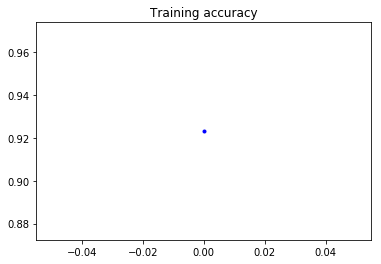

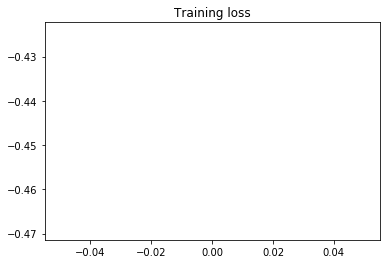

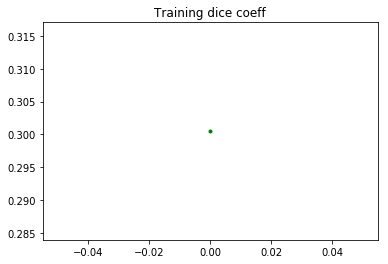

<Figure size 432x288 with 0 Axes>

In [46]:
def plot_training(history):
    acc = history.history['acc']
    print(acc)
    loss = history.history['loss']
    dice_coeff = history.history['dice_coeff']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b.')
    plt.title('Training accuracy')
    plt.figure()
    plt.plot(epochs, loss, 'r-')
    plt.title('Training loss')
    plt.figure()
    plt.plot(epochs, dice_coeff, 'g.')
    plt.title('Training dice coeff')
    plt.figure()

    plt.show()
    
plot_training(history)